In [102]:
import pandas as pd
import gmaps as gp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.patches as mpatches
from shapely.wkt import loads
from shapely.geometry import shape, MultiPolygon, Point, LineString
import geojson
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

rc={'axes.labelsize': 20, 'legend.fontsize': 15, 'xtick.labelsize': 'medium','ytick.labelsize': 'medium', 'savefig.bbox' : 'tight', 'savefig.pad_inches' : 0.2 }
plt.rcParams.update(**rc)

sns.set_style("white")
TAM_IMG=(12,8) #Tamaño de las imagenes
dest_img = "./imagenes/"

In [103]:
def guardar_imagen(nombre):
    plt.savefig(dest_img + nombre.strip().replace(' ','-') + '.png')

In [104]:
def plotear_distancias(df,x,y,titulo,label_x=None,label_y=None,color_reg='red',color_scatter='blue'):
    fig, ax = plt.subplots(figsize=TAM_IMG)
    fit = np.polyfit(df[x],df[y], deg=1)
    ax.plot(df[x], fit[0] * df[x] + fit[1], color=color_reg)
    ax.scatter(df[x], df[y],color=color_scatter)
    if(label_x and label_y):
        plt.xlabel(label_x)
        plt.ylabel(label_y)
    guardar_imagen(titulo)
    plt.show()

In [105]:
#Distancia minima entre un punto y una lista de puntos
from haversine import haversine
def distancia_minima(partida, points):
    dist_min = 9999999
    distancias=[]
    for destino in points:
        dist= round(haversine(partida,destino),1)
        if (dist<dist_min):
            dist_min = dist
    return dist

In [106]:
properati = pd.read_csv('datos/properati_2.csv')

In [107]:
properati.dtypes

created_on                     object
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: objec

In [108]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])

In [109]:
#Saco algunas columnas que no parecen servir
properati_filtrado = properati.drop( ['country_name','geonames_id','place_with_parent_names','operation','image_thumbnail'], 1)
# los geonames hacen referencia a place_name y no a la propiedad
properati_filtrado.dropna(how='all',inplace=True)
properati_filtrado = properati_filtrado.loc[properati_filtrado.price_per_m2 < 100000]
properati_filtrado['lat-lon'] = zip(properati_filtrado['lat-lon'])

## Cantidad de propiedades segun zona

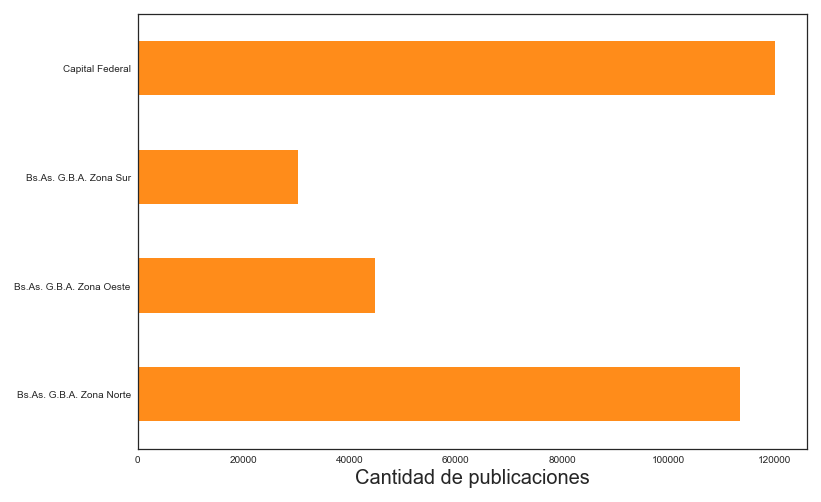

In [110]:
properati_filtrado.groupby('state_name').count()['created_on'].plot(kind='barh',figsize=TAM_IMG,color='#ff8c1a')
titulo = 'Cantidad de propiedades segun zona'
plt.xlabel('Cantidad de publicaciones')
plt.ylabel('')
guardar_imagen(titulo)
plt.show()

## Precio por m2 promedio por zona

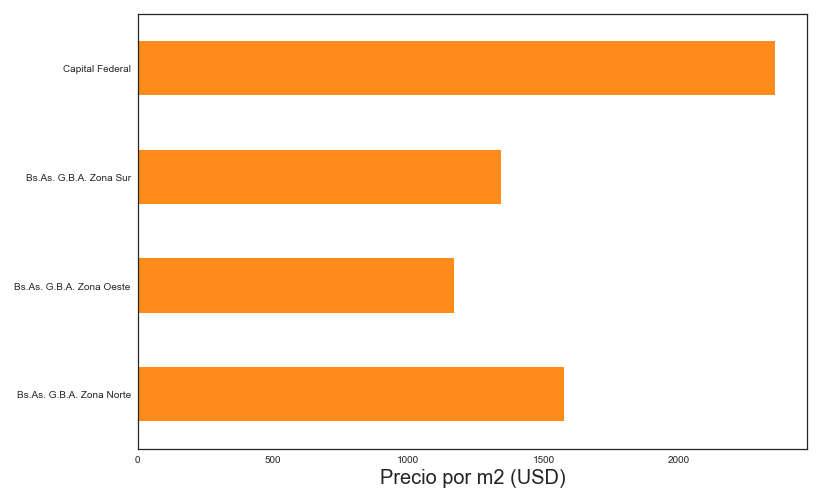

In [130]:
properati_filtrado.groupby('state_name').mean()['price_usd_per_m2'].plot(kind='barh',figsize=TAM_IMG,color='#ff8c1a')
titulo = 'Precio por m2 promedio por zona'
plt.xlabel('Precio por m2 (USD)')
plt.ylabel('')
guardar_imagen(titulo)
plt.show()

## Promedio de superficie de propiedades por zona

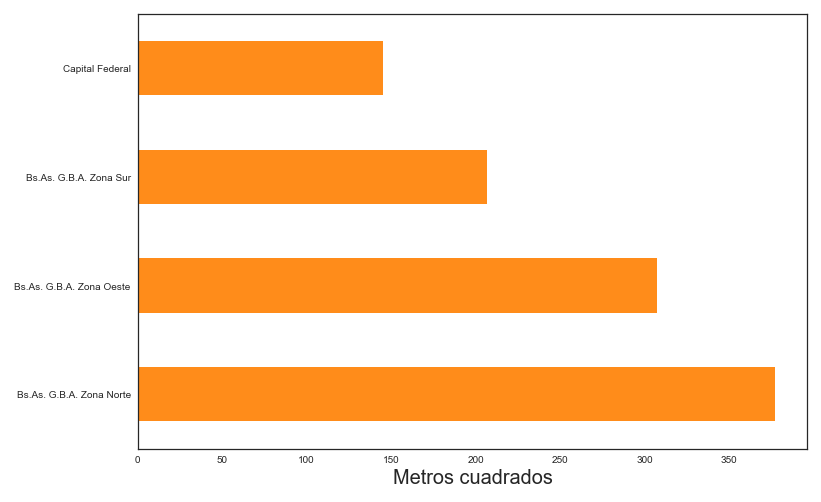

In [112]:
properati_filtrado.groupby('state_name').mean()['surface_total_in_m2'].plot(kind='barh',figsize=TAM_IMG,color='#ff8c1a')
titulo = ' Promedio de superficie de propiedades por zona'
plt.xlabel('Metros cuadrados')
plt.ylabel('')
guardar_imagen(titulo)
plt.show()

## Pisos por zona

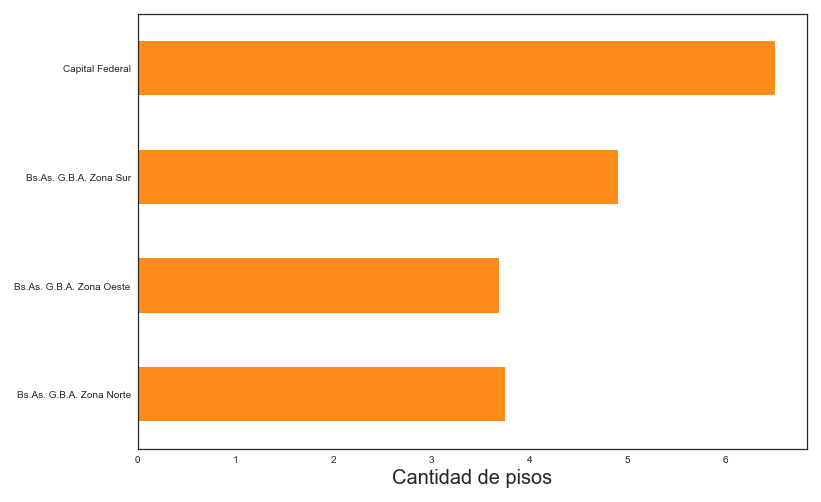

In [129]:
properati_filtrado.groupby('state_name').mean()['floor'].plot(kind='barh',figsize=TAM_IMG,color='#ff8c1a')
titulo = 'Pisos por zona'
plt.ylabel('')
plt.xlabel('Cantidad de pisos')
guardar_imagen(titulo)
plt.show()

## Cantidad de tipos de propiedades por zona

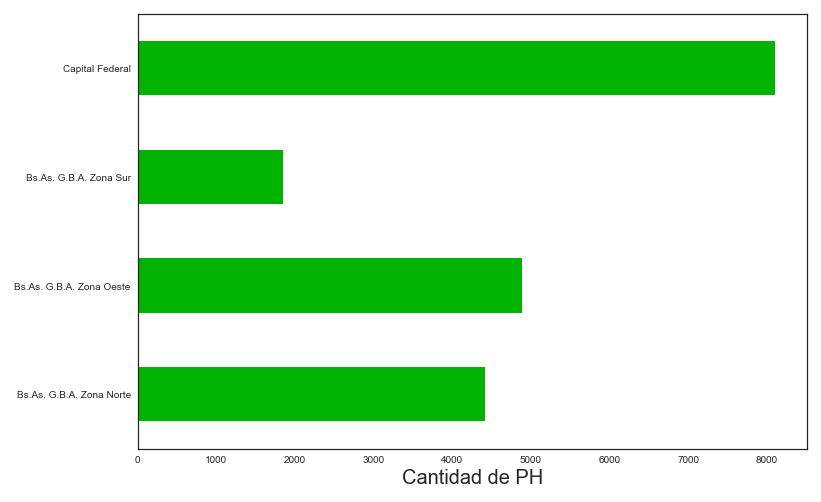

In [114]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('state_name').count()['created_on']
ranking_tipos.plot(kind='barh',figsize=TAM_IMG,color='#00b300')
titulo = 'Top PH por zonas'
plt.ylabel('')
plt.xlabel('Cantidad de PH')
guardar_imagen(titulo)
plt.show()

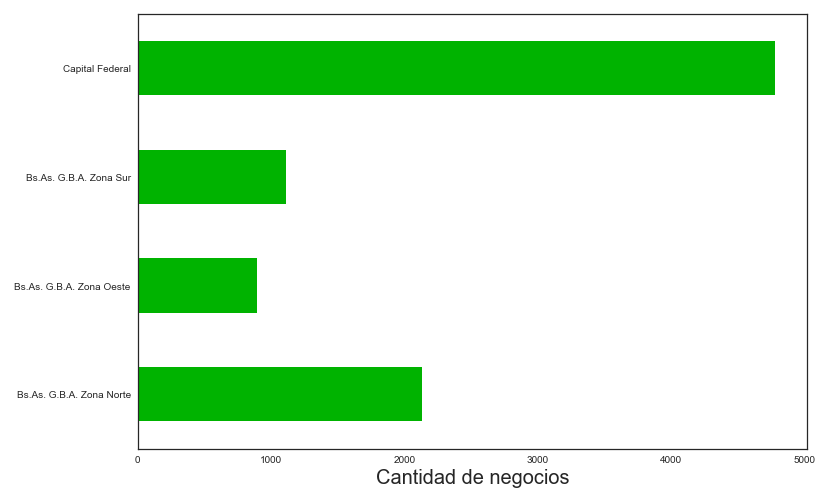

In [115]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('state_name').count()['created_on']
ranking_tipos.plot(kind='barh',figsize=TAM_IMG,color='#00b300')
titulo = 'Top negocios por zonas'
plt.ylabel('')
plt.xlabel('Cantidad de negocios')
guardar_imagen(titulo)
plt.show()

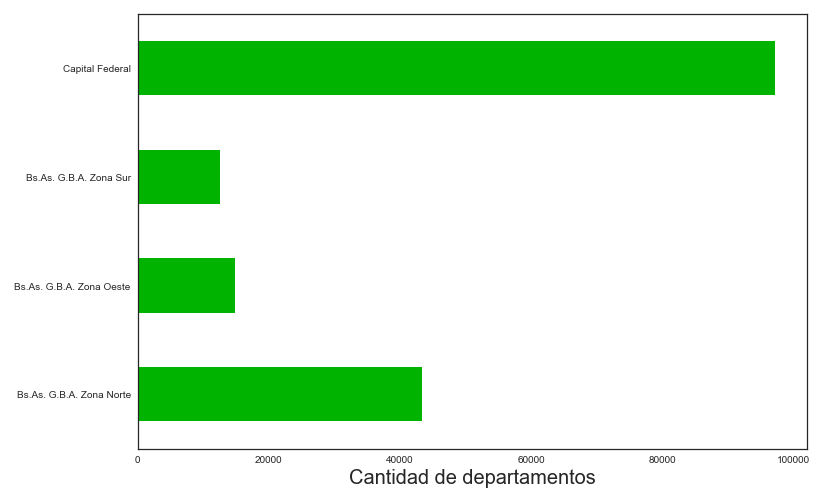

In [116]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('state_name').count()['created_on']
ranking_tipos.plot(kind='barh',figsize=TAM_IMG,color='#00b300')
titulo = 'Top departamento por zonas'
plt.ylabel('')
plt.xlabel('Cantidad de departamentos')
guardar_imagen(titulo)
plt.show()

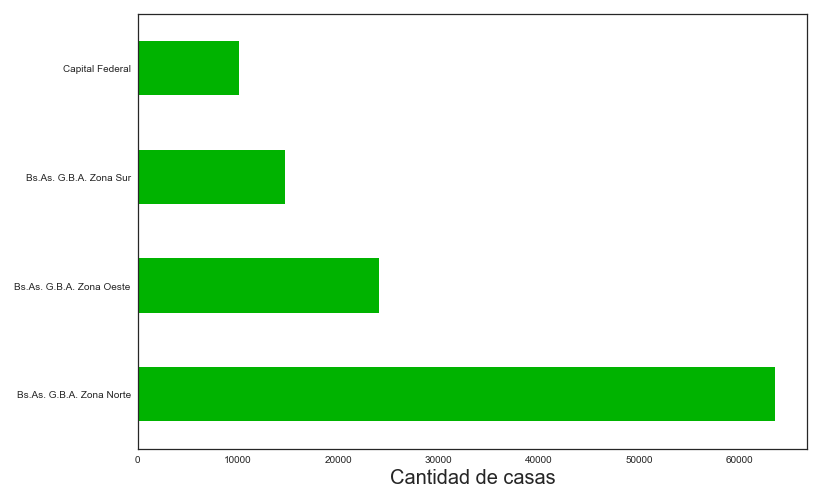

In [117]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('state_name').count()['created_on']
ranking_tipos.plot(kind='barh',figsize=TAM_IMG,color='#00b300')
titulo='Top casas por zonas'
plt.ylabel('')
plt.xlabel('Cantidad de casas')
guardar_imagen(titulo)
plt.show()

In [118]:
zona_norte = properati_filtrado.loc[properati_filtrado.state_name.str.contains('Norte')]
zona_sur = properati_filtrado.loc[properati_filtrado.state_name.str.contains('Sur')]
zona_oeste = properati_filtrado.loc[properati_filtrado.state_name.str.contains('Oeste')]
caba = properati_filtrado.loc[properati_filtrado.state_name == 'Capital Federal']

## Ranking precio por m2 por barrios

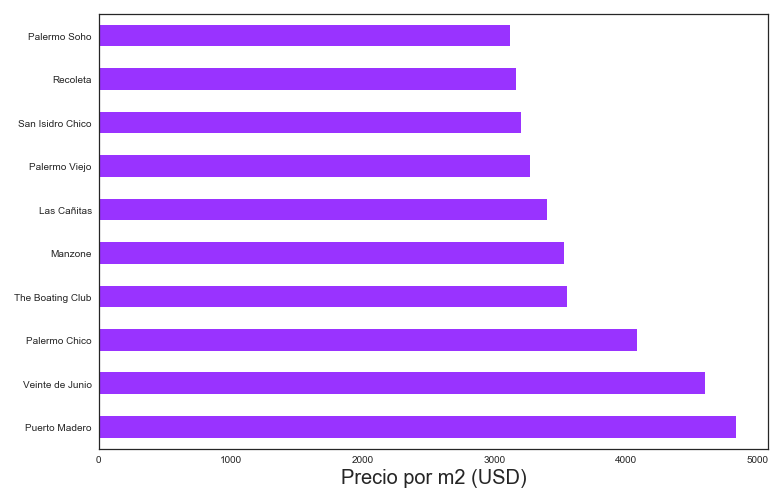

In [119]:
titulo = 'Ranking precio por m2 por barrios'
properati_filtrado.groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(10).plot(kind='barh',figsize=TAM_IMG,color='#9933ff')
plt.ylabel(' ')
plt.xlabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

## Ranking precio por m2 de tipo de propiedades por barrios

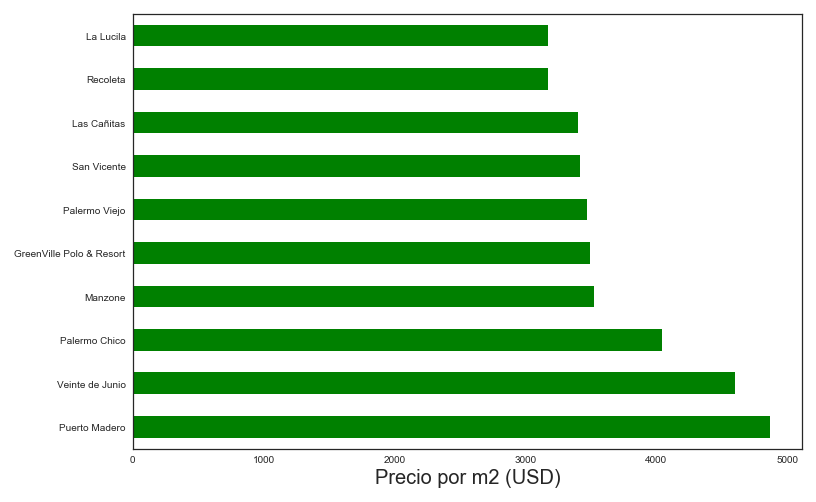

In [120]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(10)
ranking_precios_usd.plot(kind='barh',figsize=TAM_IMG,color='g')
titulo = 'Top departamentos por barrios'
plt.ylabel('')
plt.xlabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

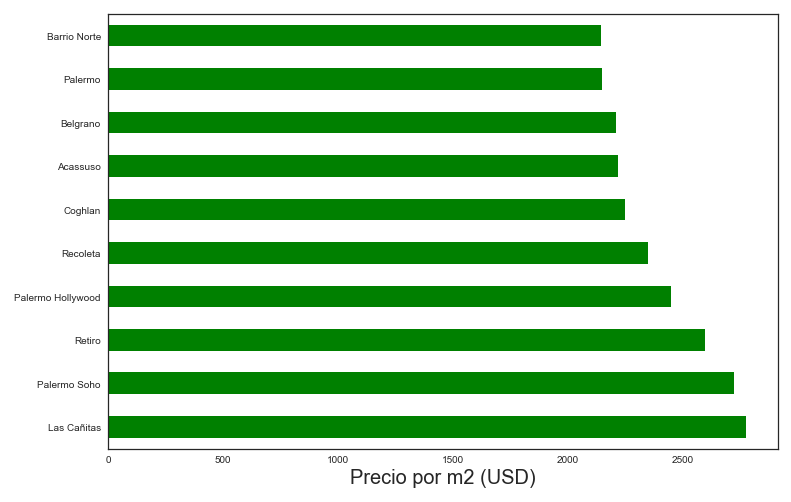

In [121]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(10)
ranking_precios_usd.plot(kind='barh',figsize=TAM_IMG,color='g')
titulo = 'Top PH por barrios'
plt.ylabel('')
plt.xlabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

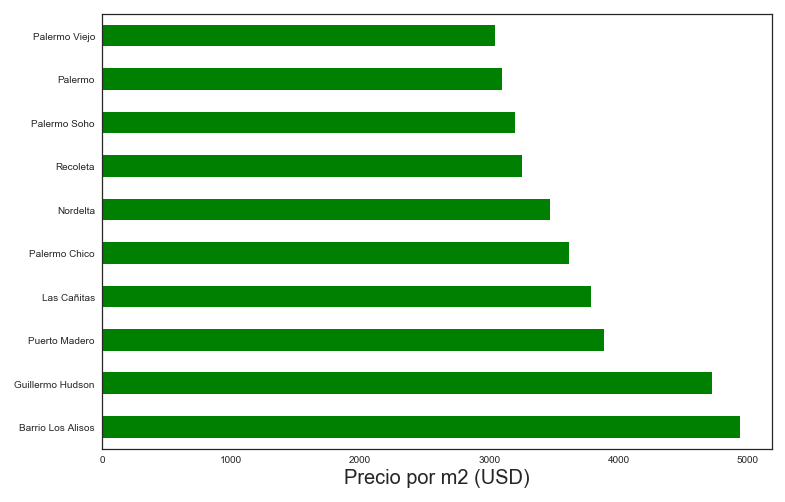

In [122]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(10)
ranking_precios_usd.plot(kind='barh',figsize=TAM_IMG,color='g')
titulo = 'Top negocios por barrios'
plt.ylabel('')
plt.xlabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

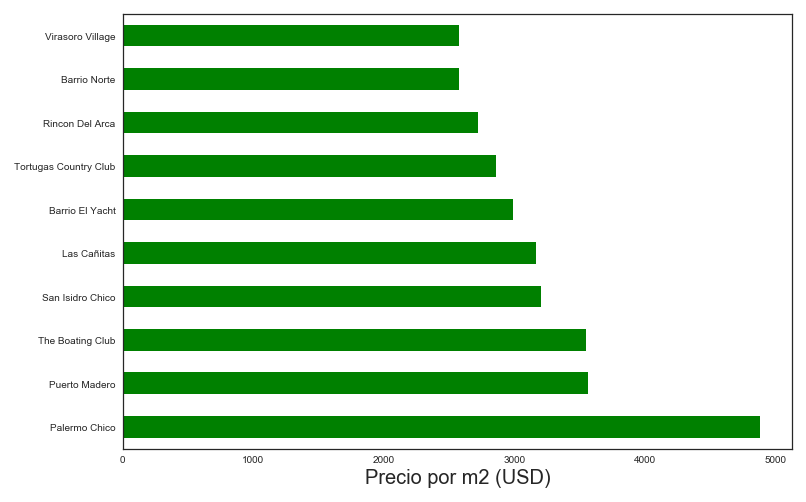

In [123]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(10)
ranking_precios_usd.plot(kind='barh',figsize=TAM_IMG,color='g')
titulo = 'Top casas por barrios'
plt.ylabel('')
plt.xlabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

## Ranking cantidad de propiedades por barrios


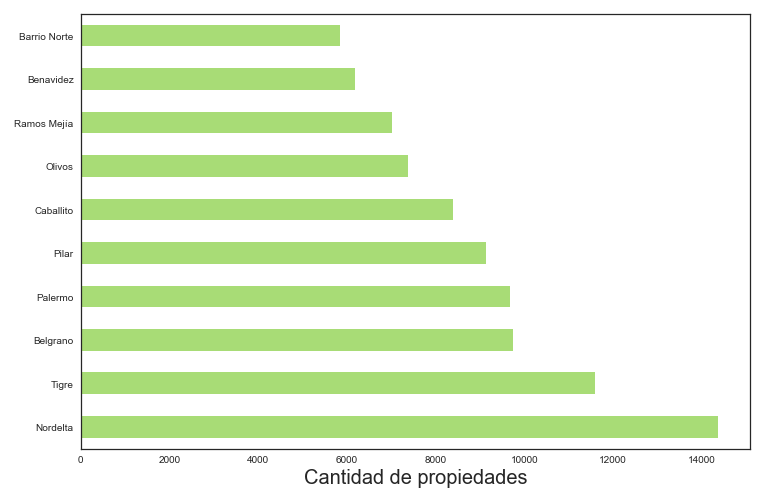

In [124]:
ranking_tipos = properati_filtrado.groupby('place_name').count()['created_on'].sort_values(ascending=False).head(10)
ranking_tipos.plot(kind='barh',figsize=TAM_IMG,color='#a8dc76')
titulo = 'Cantidad de propiedades por barrio'
plt.ylabel('')
plt.xlabel('Cantidad de propiedades')
guardar_imagen(titulo)
plt.show()

## Ranking cantidad de tipos de propiedades por barrios

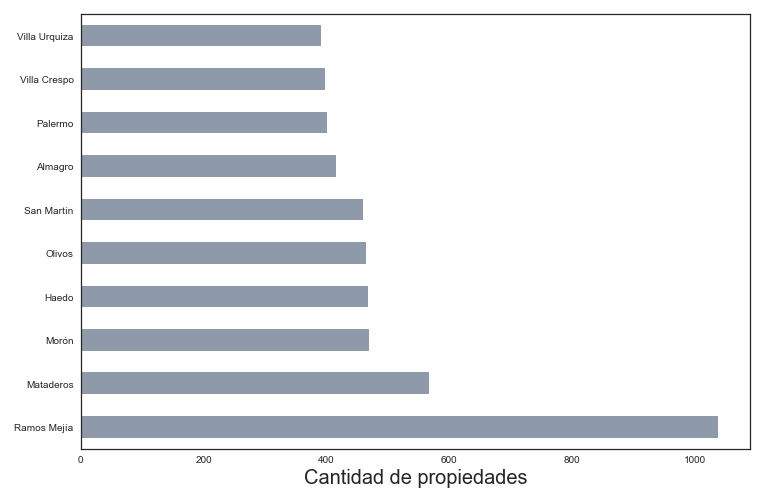

In [125]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(10)
ranking_tipos.plot(kind='barh',figsize=TAM_IMG,color='#8e99aa')
titulo = 'Cantidad PH por barrio'
plt.ylabel('')
plt.xlabel('Cantidad de propiedades')
guardar_imagen(titulo)
plt.show()

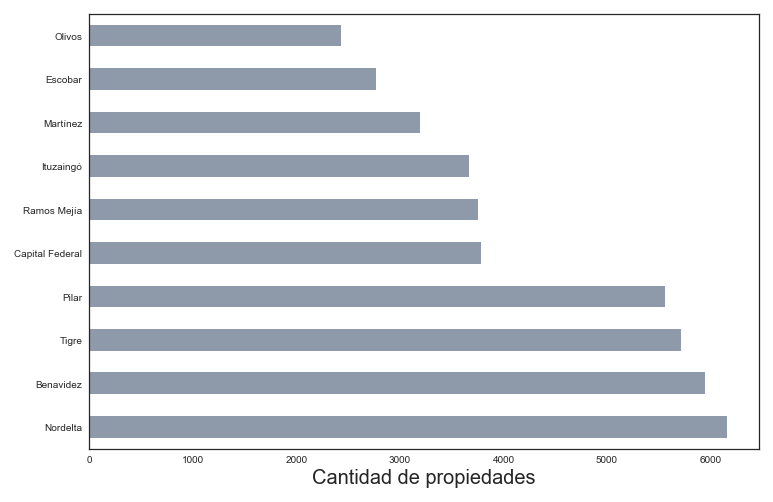

In [126]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(10)
ranking_tipos.plot(kind='barh',figsize=TAM_IMG,color='#8e99aa')
titulo = 'Cantidad de casas por barrio'
plt.ylabel('')
plt.xlabel('Cantidad de propiedades')
guardar_imagen(titulo)
plt.show()

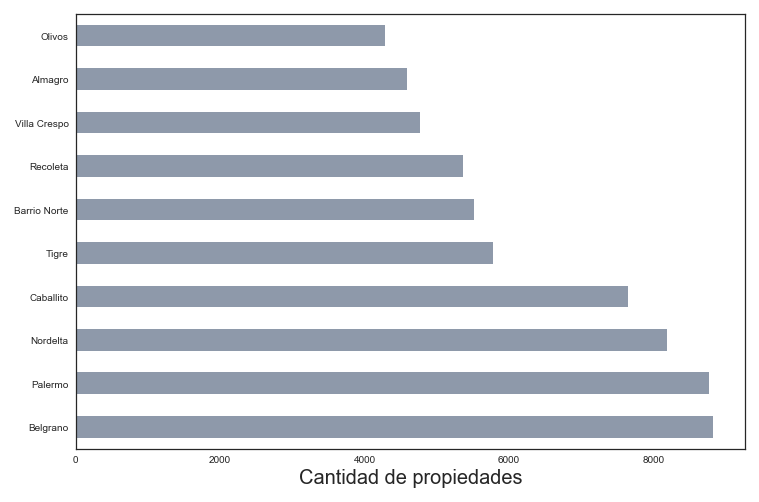

In [127]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(10)
ranking_tipos.plot(kind='barh',figsize=TAM_IMG,color='#8e99aa')
titulo = 'Cantidad de departamentos por barrios'
plt.ylabel('')
plt.xlabel('Cantidad de propiedades')
guardar_imagen(titulo)
plt.show()

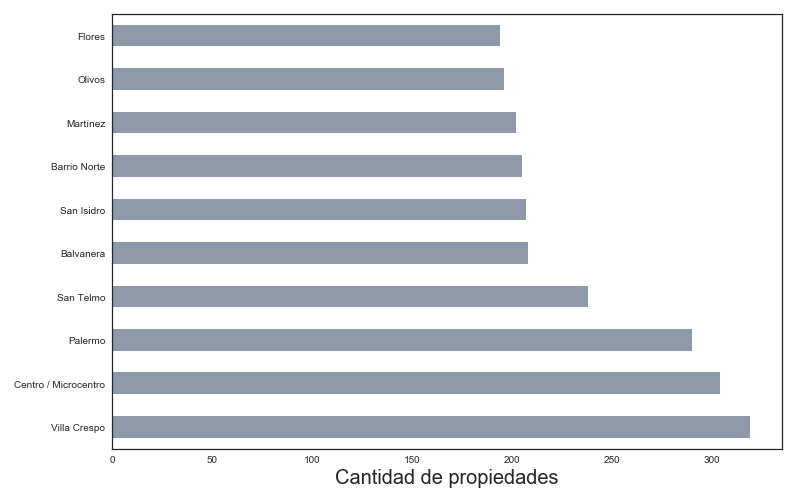

In [128]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(10)
ranking_tipos.plot(kind='barh',figsize=TAM_IMG,color='#8e99aa')
titulo='Cantidad de negocios por barrio'
plt.ylabel('')
plt.xlabel('Cantidad de propiedades')
guardar_imagen(titulo)
plt.show()

In [28]:
propiedades_full=properati

In [29]:
properties_by_type=propiedades_full[['place_name','property_type']]


In [30]:
properties_by_type_and_total=properties_by_type.groupby('place_name').count().reset_index()

In [31]:
properties_by_type_and_total.columns=['place_name','total_properties']
properties_by_type_and_total

,place_name,total_properties
0,Country Maschwitz Club,55
1,los alamos,5
2,9 de Abril,4
3,Abasto,625
4,Abril Club de Campo,90
5,Acacias Blancas,184
6,Acassuso,1999
7,Adrogué,2278
8,Aero Country Club,15
9,Aeropuerto Internacional Ezeiza,26


In [32]:
properties_by_type=properties_by_type.groupby('place_name').apply(lambda x: x['property_type'].value_counts()).reset_index()
properties_by_type=pd.pivot_table(properties_by_type,index=['place_name'],columns=['level_1']).reset_index()
properties_by_type

place_name property_type                    \
level_1                                                PH apartment   house   
0                    Country Maschwitz Club           NaN       NaN    55.0   
1                                los alamos           NaN       4.0     1.0   
2                                9 de Abril           NaN       NaN     2.0   
3                                    Abasto          71.0     451.0    61.0   
4                       Abril Club de Campo           NaN       NaN    90.0   
5                           Acacias Blancas           NaN       NaN   184.0   
6                                  Acassuso          52.0     686.0  1156.0   
7                                   Adrogué          72.0     616.0  1506.0   
8                         Aero Country Club           NaN      15.0     NaN   
9           Aeropuerto Internacional Ezeiza           NaN       NaN    26.0   
10                                Agronomía          49.0     249.0    26.0   
11                 Albanueva Barrio Cerrado           NaN      23.0    35.0   
12                               Aldo Bonzi           9.0       6.0    43.0   
13                           Alejandro Korn           NaN       1.0    48.0   
14                         Alejandro Petión           NaN       NaN    14.0   
15                                  Almagro         487.0    5625.0   186.0   
16                          Almirante Brown           6.0      46.0   141.0   
17                                 Altamira           NaN       NaN    49.0   
18                        Altos de Hudson I           NaN       1.0     3.0   
19                       Altos de Hudson II           NaN      34.0    26.0   
20                Altos de Manzanares 1 y 2           NaN       NaN    18.0   
21                          Altos de Matheu           NaN       NaN    18.0   
22                           Altos del Golf           NaN       NaN    41.0   
23                          Altos del Pilar           NaN       NaN    51.0   
24                     Armenia Country Club           NaN       4.0    19.0   
25                             Arturo Seguí           NaN       NaN    20.0   
26                               Avellaneda         150.0    1109.0   223.0   
27                            Bahía del Sol           NaN       1.0    10.0   
28                                Balvanera         299.0    3626.0    79.0   
29                                 Banfield         143.0    1073.0  1162.0   
..                                      ...           ...       ...     ...   
587                          Villa Numancia           NaN       NaN     4.0   
588                           Villa Ortuzar          53.0     424.0    40.0   
589                           Villa Pacheco           NaN       NaN    13.0   
590                        Villa Pueyrredón         224.0     627.0   213.0   
591                             Villa Raffo          18.0      81.0    31.0   
592                              Villa Real          92.0      91.0    66.0   
593                         Villa Riachuelo          12.0      13.0    21.0   
594                              Villa Rosa           9.0     216.0   246.0   
595                          Villa San Luis           NaN       NaN     1.0   
596                        Villa Santa Rita          85.0     309.0   106.0   
597                         Villa Sarmiento         163.0     789.0   618.0   
598                           Villa Soldati          19.0      65.0    12.0   
599                             Villa Tesei          20.0      69.0   185.0   
600                           Villa Udaondo          11.0       5.0   421.0   
601                           Villa Urquiza         548.0    5377.0   375.0   
602                          Villa Vatteone           4.0       1.0    14.0   
603                           Villa de Mayo           2.0      71.0   210.0   
604                        Villa del Parque         245.0    1493.0   279.0   
605 

In [33]:
 properties_by_type.columns=['place_name','PH','apartment','house','store']

In [34]:
properties_by_type_and_total=pd.merge(properties_by_type,properties_by_type_and_total,on = 'place_name', how='left')

In [35]:
properties_by_type_and_total_mean=properties_by_type_and_total

In [36]:
properties_by_type_and_total_mean=properties_by_type_and_total_mean.fillna(value=0)

In [37]:
properties_by_type_and_total_mean.loc[:,('apartment_percent')]=properties_by_type_and_total_mean['apartment']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('PH_percent')]=properties_by_type_and_total_mean['PH']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('house_percent')]=properties_by_type_and_total_mean['house']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('store_percent')]=properties_by_type_and_total_mean['store']/properties_by_type_and_total_mean['total_properties']

In [38]:
properties_by_type_and_total_mean

,place_name,PH,apartment,house,store,total_properties,apartment_percent,PH_percent,house_percent,store_percent
0,Country Maschwitz Club,0.0,0.0,55.0,0.0,55,0.000000,0.000000,1.000000,0.000000
1,los alamos,0.0,4.0,1.0,0.0,5,0.800000,0.000000,0.200000,0.000000
2,9 de Abril,0.0,0.0,2.0,2.0,4,0.000000,0.000000,0.500000,0.500000
3,Abasto,71.0,451.0,61.0,42.0,625,0.721600,0.113600,0.097600,0.067200
4,Abril Club de Campo,0.0,0.0,90.0,0.0,90,0.000000,0.000000,1.000000,0.000000
5,Acacias Blancas,0.0,0.0,184.0,0.0,184,0.000000,0.000000,1.000000,0.000000
6,Acassuso,52.0,686.0,1156.0,105.0,1999,0.343172,0.026013,0.578289,0.052526
7,Adrogué,72.0,616.0,1506.0,84.0,2278,0.270413,0.031607,0.661106,0.036874
8,Aero Country Club,0.0,15.0,0.0,0.0,15,1.000000,0.000000,0.000000,0.000000
9,Aeropuerto Internacional Ezeiza,0.0,0.0,26.0,0.0,26,0.000000,0.000000,1.000000,0.000000


In [39]:
properties_by_usd_m2=propiedades_full[['place_name','price_usd_per_m2']].dropna().groupby('place_name').mean().reset_index()

In [40]:
properties_by_m2_and_type_mean=pd.merge(properties_by_usd_m2,properties_by_type_and_total_mean,on='place_name',how='left')

In [41]:
properties_by_m2_and_type_mean_greater_than_20 = properties_by_m2_and_type_mean[properties_by_m2_and_type_mean['total_properties']>20]\
[['apartment_percent','PH_percent','store_percent','house_percent','price_usd_per_m2']].groupby('price_usd_per_m2').mean().reset_index()

In [42]:
def agrupar_scatter(df,x,y,color,label):
    plot=ax.scatter(df[x], df[y],color=color,label=label)

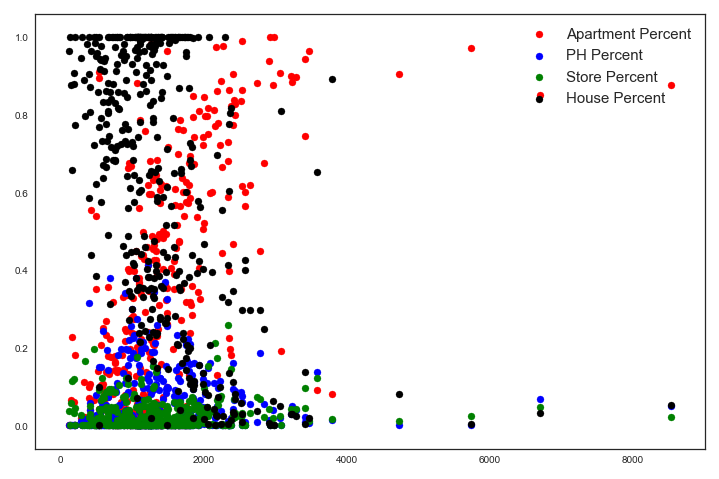

In [43]:
fig, ax = plt.subplots(figsize=TAM_IMG)
agrupar_scatter(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','apartment_percent','red','Apartment Percent')
agrupar_scatter(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','PH_percent','blue','PH Percent')
agrupar_scatter(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','store_percent','green','Store Percent')
agrupar_scatter(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','house_percent','black','House Percent')
plt.legend(loc='upper right')
plt.show()

In [44]:
def aproximaciones_lineales_agrupadas(df,x,y,color,ax,label):
    fit = np.polyfit(df[x],df[y], deg=1)
    ax.plot(df[x], fit[0] * df[x] + fit[1], color=color,label=label)


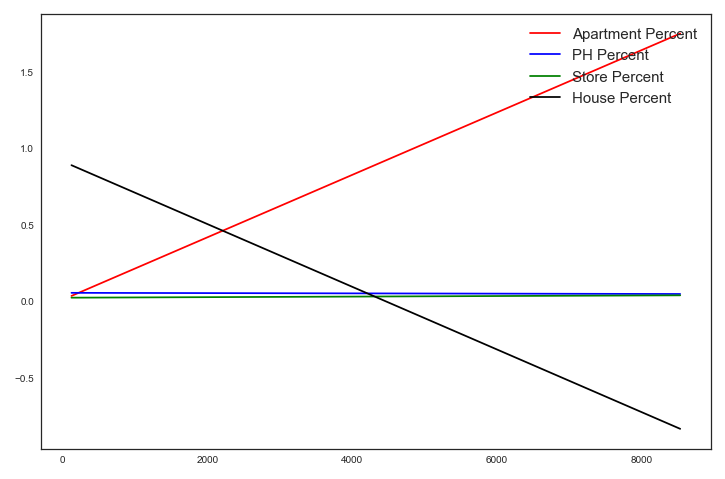

In [45]:
fig, ax = plt.subplots(figsize=TAM_IMG)
aproximaciones_lineales_agrupadas(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','apartment_percent','red',ax,'Apartment Percent')
aproximaciones_lineales_agrupadas(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','PH_percent','blue',ax,'PH Percent')
aproximaciones_lineales_agrupadas(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','store_percent','green',ax,'Store Percent')
aproximaciones_lineales_agrupadas(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','house_percent','black',ax,'House Percent')
plt.legend(loc='upper right')
plt.show()


## propiedades con patio y a estrenar

In [46]:
news_properties_with_garden=pd.DataFrame({'place_name':propiedades_full['place_name']\
                                          ,'description':propiedades_full['description'],'price_usd_per_m2':propiedades_full['price_usd_per_m2']})


In [47]:
news_properties_with_garden=news_properties_with_garden.dropna(how='any')

In [48]:
news_properties_with_garden.loc[:,'has_garden']=news_properties_with_garden.loc[:,'description'].str.lower().str.contains('patio')
news_properties_with_garden.loc[:,'is_new']=news_properties_with_garden.loc[:,'description'].str.lower().str.contains('estrenar')

In [49]:
#news_properties_with_garden.plot.bar()

## Veamos cuales son las ciudades que vendieron más casas con patio

In [50]:
properties_total=propiedades_full[['place_name','property_type']]
#Calculo el total de las ventas por ciudad
properties_total=properties_total.groupby('place_name').count().reset_index()

In [51]:
properties_total.columns=['place_name','total']

In [52]:
#Calculo la cantidad de casas con jardines vendidas por ciudad
properties_garden_count=news_properties_with_garden[['place_name','has_garden']][news_properties_with_garden['has_garden']]\
.groupby('place_name').count().reset_index()

In [53]:
#Merge entre cantidad de casas con jardines con cantidad total de casas
properties_garden_count=pd.merge(properties_garden_count,properties_total,on='place_name',how='left')

In [54]:
properties_garden_count.loc[:,('has_garden_percent')]=properties_garden_count['has_garden']/properties_garden_count['total']

In [55]:
#Elimino los datos con menores a 50 ventas.
properties_garden_count=properties_garden_count[properties_garden_count['total']>50]

In [56]:
property_by_price_m2_and_place=properati_filtrado.groupby('place_name').mean()['price_usd_per_m2'].reset_index()
properties_garden_count=pd.merge(properties_garden_count,property_by_price_m2_and_place,on='place_name',how='left')
properties_garden_count=properties_garden_count[properties_garden_count['price_usd_per_m2']<4000]

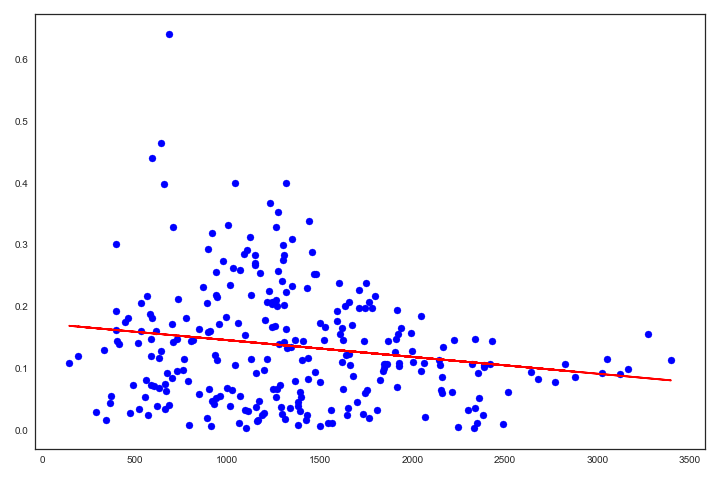

In [57]:
plotear_distancias(properties_garden_count,'price_usd_per_m2','has_garden_percent','precio promedio vs porcentaje jardin')

## Mismo análisis con propiedades a estrenar

In [58]:
#Calculo la cantidad de casas con jardines vendidas por ciudad
news_properties_count=news_properties_with_garden[['place_name','is_new']][news_properties_with_garden['is_new']]\
.groupby('place_name').count().reset_index()
#Merge entre cantidad de casas a estrenar con cantidad total de casas
news_properties_count=pd.merge(news_properties_count,properties_total,on='place_name',how='left')


In [59]:
news_properties_count.loc[:,('is_new_percent')]=news_properties_count['is_new']/news_properties_count['total']

In [60]:
#Elimino los datos con menores a 50 ventas.
news_properties_count=news_properties_count[news_properties_count['total']>50]

In [61]:
property_by_price_m2_and_place=properati_filtrado.groupby('place_name').mean()['price_usd_per_m2'].reset_index()
news_properties_count=pd.merge(news_properties_count,property_by_price_m2_and_place,on='place_name',how='left')
news_properties_count=news_properties_count[news_properties_count['price_usd_per_m2']<4000]

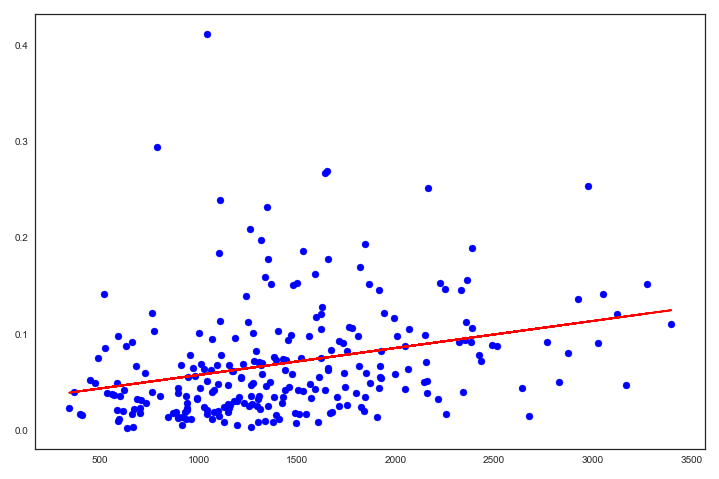

In [62]:
plotear_distancias(news_properties_count,'price_usd_per_m2','is_new_percent','precio promedio vs porcentaje casas nuevas')

## TIpo que se vende mas

In [63]:
top_tipos=properati_filtrado.groupby('property_type')['price'].count().sort_values()
top_tipos

property_type
store          8917
PH            19275
house        112521
apartment    167894
Name: price, dtype: int64

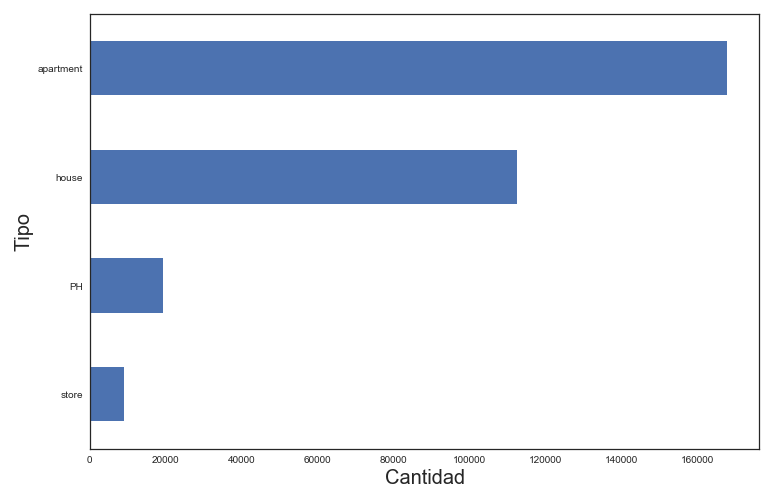

In [64]:
top_tipos.plot(kind='barh',figsize=TAM_IMG)
titulo = 'Tipo mas popular'
plt.ylabel('Tipo')
plt.xlabel('Cantidad')
guardar_imagen(titulo)
plt.show()

## Promedio de precio por tipo

In [65]:
promedio_por_tipo = properati_filtrado.groupby('property_type')['price_usd_per_m2'].mean()

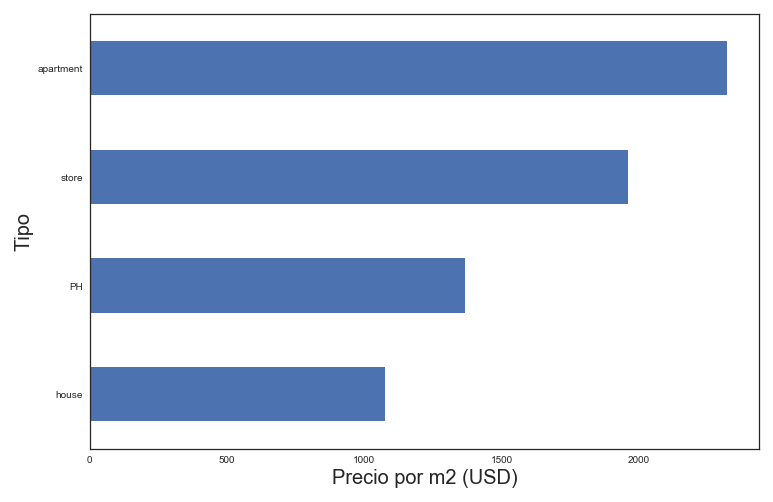

In [66]:
promedio_por_tipo.sort_values().plot(kind='barh',figsize=TAM_IMG)
titulo = 'Promedio de precios por tipo'

plt.ylabel('Tipo')
plt.xlabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

## Promedio precio por m2 por mes

In [67]:
properati_filtrado['fecha'] = [(x.year,x.month) for x in properati_filtrado['created_on'] ]
propiedades_por_mes = properati_filtrado.loc[properati_filtrado['fecha']>(2015,1)]
propiedades_por_mes = propiedades_por_mes.groupby(['property_type',properati_filtrado['fecha']])

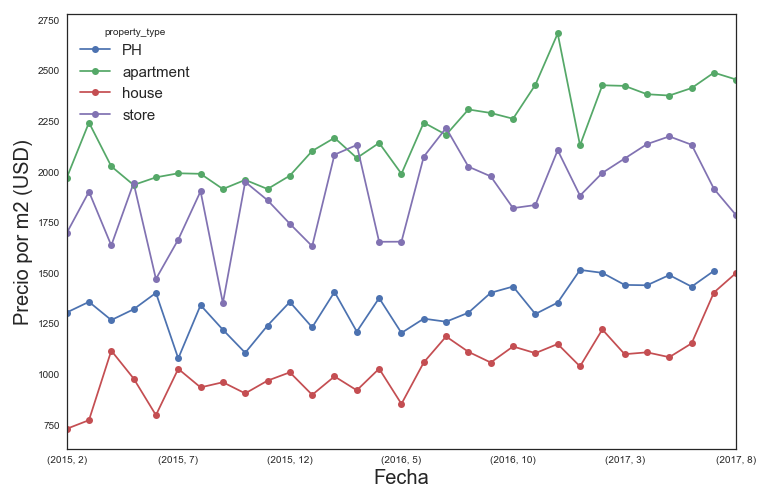

In [68]:
promedio_por_tipo_y_mes= propiedades_por_mes['price_usd_per_m2'].mean().unstack(level=0)
promedio_por_tipo_y_mes.plot(kind='line',marker="o",figsize=TAM_IMG)
titulo = 'Promedio mensual del precio por m2'
plt.ylabel('Precio por m2 (USD)')
plt.xlabel('Fecha')

guardar_imagen(titulo)
plt.show()

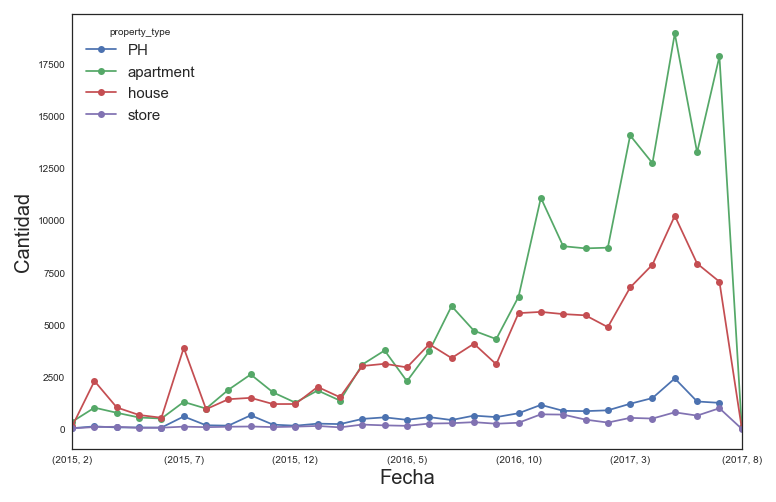

In [69]:
cantidad_por_mes = propiedades_por_mes.count()['created_on'].unstack(level=0)
cantidad_por_mes.plot(kind='line',marker="o",figsize=TAM_IMG)
titulo = 'Cantidad de propiedades al paso del tiempo'
plt.ylabel('Cantidad')
plt.xlabel('Fecha')

guardar_imagen(titulo)
plt.show()

## Cantidad de pisos a traves del tiempo

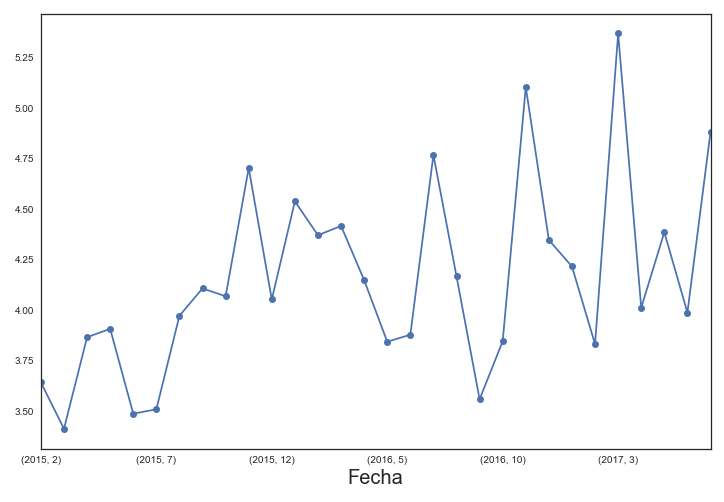

In [70]:
pisos_vs_tiempo = properati_filtrado.loc[properati_filtrado.floor < 55] #https://es.wikipedia.org/wiki/Anexo:Edificios_m%C3%A1s_altos_de_Argentina
pisos_vs_tiempo = pisos_vs_tiempo.loc[pisos_vs_tiempo['fecha']>(2015,1)]
pisos_vs_tiempo.groupby('fecha').mean()['floor'].plot(kind='line',marker="o",figsize=TAM_IMG)
titulo = 'Cantidad de pisos a traves del tiempo'
plt.xlabel('Fecha')
guardar_imagen(titulo)
plt.show()

##  Mayor cantidad de publicaciones respecto de las expensas y el precio total

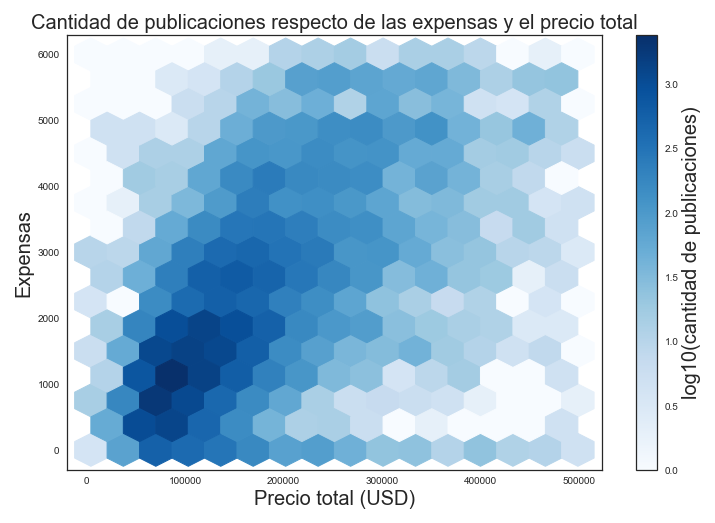

In [71]:
expensas_vs_precio = properati_filtrado.loc[(properati_filtrado['property_type'] == 'apartment') & (properati_filtrado.expenses<6000) & (properati_filtrado.expenses>0) & (properati_filtrado.price_aprox_usd <500000)].loc[:,('price_aprox_usd','expenses')].dropna() #hay unas expensas mal
plt.figure(figsize=TAM_IMG)
plt.hexbin(expensas_vs_precio['price_aprox_usd'],expensas_vs_precio['expenses'], gridsize=15,bins='log',cmap='Blues')
cb = plt.colorbar()
cb.set_label('log10(cantidad de publicaciones)')
titulo = 'Cantidad de publicaciones respecto de las expensas y el precio total'
plt.title(titulo,size=20)
plt.ylabel('Expensas')
plt.xlabel('Precio total (USD)')
guardar_imagen(titulo)
plt.show()

##  Mayor cantidad de publicaciones respecto de las expensas y el precio por m2

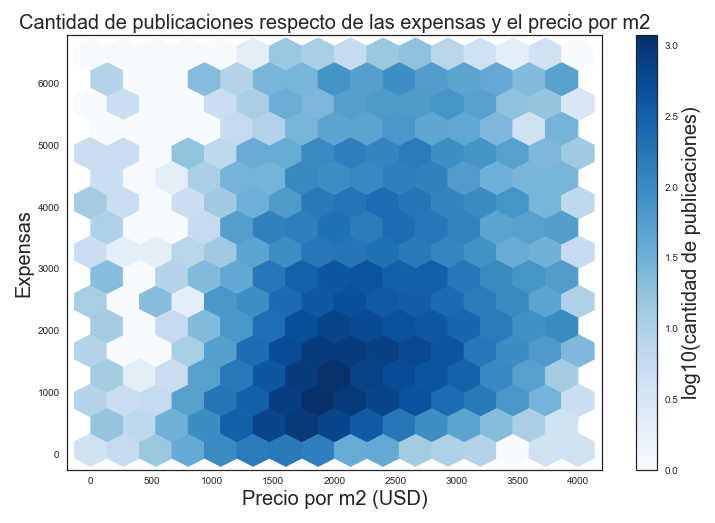

In [72]:
expensas_vs_precio = properati_filtrado.loc[(properati_filtrado['property_type'] == 'apartment') & (properati_filtrado.price_usd_per_m2<4000) & (properati_filtrado.expenses>50) & (properati_filtrado.expenses<6500)].loc[:,('price_usd_per_m2','expenses')].dropna() #hay unas expensas mal
plt.figure(figsize=TAM_IMG)
sns.set_style("white")
plt.hexbin(expensas_vs_precio['price_usd_per_m2'],expensas_vs_precio['expenses'], gridsize=15,bins='log',cmap='Blues')
cb = plt.colorbar()
cb.set_label('log10(cantidad de publicaciones)')
titulo = 'Cantidad de publicaciones respecto de las expensas y el precio por m2'
plt.title(titulo,size=20)
plt.ylabel('Expensas')
plt.xlabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

##  Superficie descubierta vs precio 

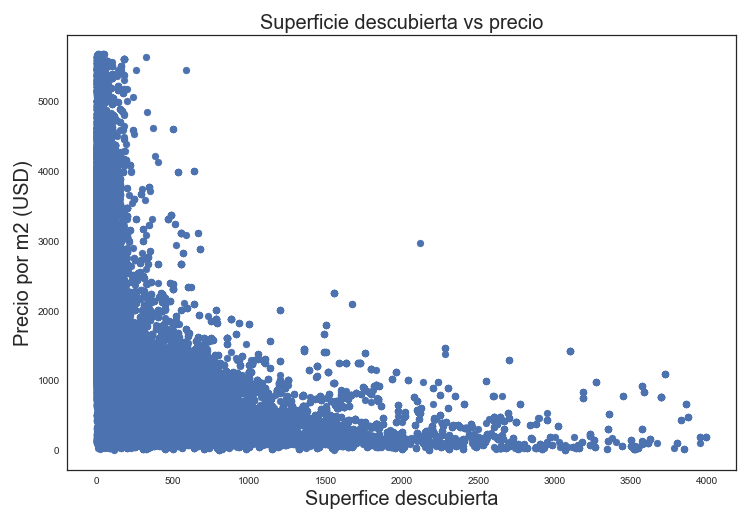

In [73]:
properati_filtrado.loc[:,'superficie_descubierta'] = properati_filtrado['surface_total_in_m2'] - properati_filtrado['surface_covered_in_m2']
properati_filtrado.loc[:,'superficie_descubierta'] = properati_filtrado.loc[properati_filtrado.superficie_descubierta>0 &((properati_filtrado.property_type == "PH")|(properati_filtrado.property_type == "apartment"))]
precio_vs_descubierto= properati_filtrado.loc[:,('price_usd_per_m2','superficie_descubierta')].dropna()
precio_vs_descubierto.groupby('superficie_descubierta').mean()
precio_vs_descubierto = precio_vs_descubierto.loc[precio_vs_descubierto.superficie_descubierta<4000]

plt.figure(figsize=TAM_IMG)
plt.scatter(precio_vs_descubierto['superficie_descubierta'],precio_vs_descubierto['price_usd_per_m2'])
titulo='Superficie descubierta vs precio'
plt.title(titulo,size=20)
plt.ylabel('Precio por m2 (USD)')
plt.xlabel('Superfice descubierta')
guardar_imagen(titulo)
plt.show()

##  Precio por m2 vs habitaciones

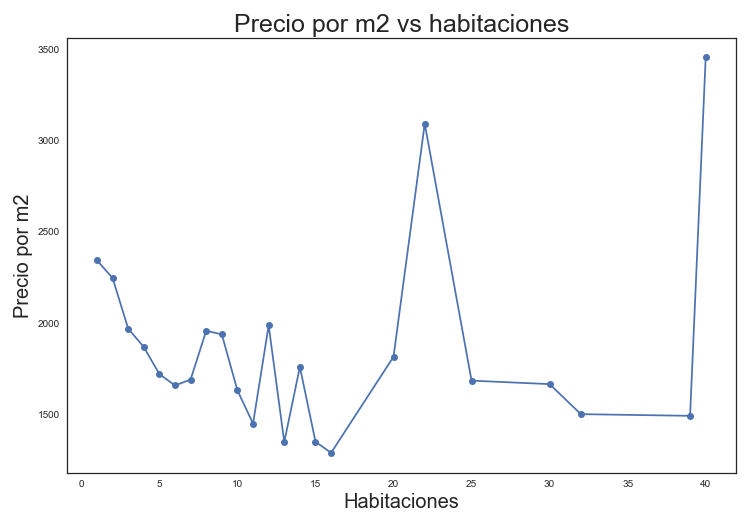

In [74]:
precio_vs_habs= properati_filtrado.loc[:,('price_usd_per_m2','rooms')].dropna()
precio_vs_habs= precio_vs_habs.groupby('rooms').mean()

titulo ='Precio por m2 vs habitaciones'
plt.figure(figsize=TAM_IMG)
plt.xlabel('Habitaciones')
plt.ylabel('Precio por m2')
plt.title(titulo,size= 25)
plt.plot(precio_vs_habs,marker="o")
guardar_imagen(titulo)
plt.show()

##  Piso del departamento vs precio por m2

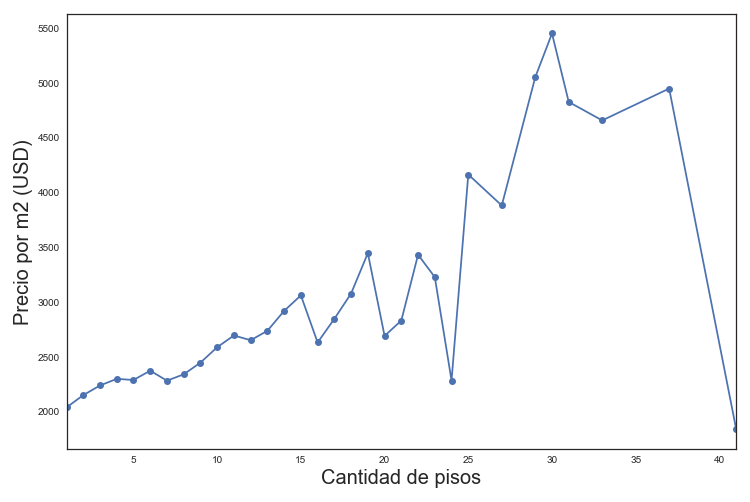

In [75]:
piso_vs_precio = properati_filtrado.loc[:,('price_usd_per_m2','floor')].dropna()
piso_vs_precio = piso_vs_precio.loc[piso_vs_precio.floor < 55] #https://es.wikipedia.org/wiki/Anexo:Edificios_m%C3%A1s_altos_de_Argentina
piso_vs_precio = piso_vs_precio.groupby(properati_filtrado.floor)
piso_vs_precio = piso_vs_precio.mean()['price_usd_per_m2']
piso_vs_precio.plot(kind='line',marker="o",figsize=TAM_IMG)

titulo ='Piso del departamento vs precio por m2'
plt.ylabel('Precio por m2 (USD)')
plt.xlabel('Cantidad de pisos')
guardar_imagen(titulo)
plt.show()

##  Piso del departamento vs expensas

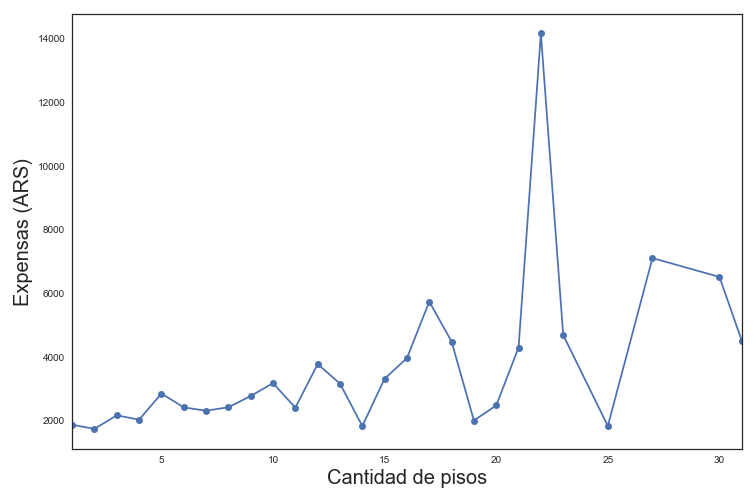

In [76]:
piso_vs_expensas = properati_filtrado.loc[:,('floor','expenses')].dropna(subset=['expenses'])
piso_vs_expensas = piso_vs_expensas.loc[properati_filtrado.floor <50]
piso_vs_expensas = piso_vs_expensas.groupby(properati_filtrado.floor).mean()['expenses']
piso_vs_expensas.plot(kind='line',marker="o",figsize=TAM_IMG)

titulo = 'Piso del departamento vs expensas'
plt.ylabel('Expensas (ARS)')
plt.xlabel('Cantidad de pisos')

guardar_imagen(titulo)
plt.show()

In [77]:
caba_para_mapa = caba.dropna(subset= ['lat','lon'])
caba_para_mapa = caba_para_mapa.loc[(caba_para_mapa.lat > -35) & (caba_para_mapa.lat < -34) & (caba_para_mapa.lon > -58.7)] #preparo para calcular distancias
caba_para_mapa['lat-lon'] = [(x, y) for x,y in zip(caba_para_mapa['lat'], caba_para_mapa['lon'])] #preparo para calcular distancias
#gp.scatter(caba_para_mapa['lat'], caba_para_mapa['lon'],colors='blue') #reviso si filtre bien "puntos malos"

In [78]:
todo_para_mapa = properati_filtrado.dropna(subset= ['lat','lon'])
todo_para_mapa['lat-lon'] = [(x, y) for x,y in zip(todo_para_mapa['lat'], todo_para_mapa['lon'])] #preparo para calcular distancias
todo_para_mapa = todo_para_mapa.loc[(todo_para_mapa.lat > -36) & (todo_para_mapa.lat < -34.2) & (todo_para_mapa.lon > -59)] 
#gp.scatter(todo_para_mapa['lat'], todo_para_mapa['lon'],colors='blue') #reviso si filtre bien "puntos malos"

/home/ale/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Relacion entre distancia a boca de subte vs precio por m2 CABA

In [79]:
subtes = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-subte.csv')
subtes['lat-lon'] = [(x, y) for x,y in zip(subtes['y'], subtes['x'])]

In [80]:
#gp.scatter(subtes['y'], subtes['x'],colors='red')

In [81]:
caba_para_mapa['dist_a_subte'] = [distancia_minima(x, list(subtes['lat-lon'])) for x in caba_para_mapa['lat-lon']]

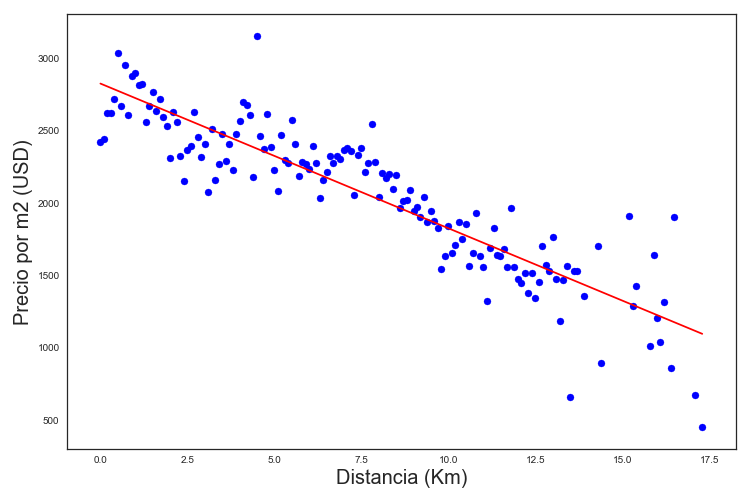

In [82]:
resultados = caba_para_mapa.loc[:,('dist_a_subte','price_usd_per_m2')].groupby('dist_a_subte').mean().reset_index()
titulo = 'Relacion entre distancia a boca de subte vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_subte','price_usd_per_m2',titulo,'Distancia (Km)','Precio por m2 (USD)')

In [83]:
colectivos = pd.read_csv('datos/datasets/CABA/latlon/paradas-de-colectivo.csv')

In [84]:
#gp.scatter(colectivos['Y'], colectivos['X'],colors='red')

In [85]:
metrobus = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-metrobus.csv')

In [86]:
#gp.scatter(metrobus['Y'], metrobus['X'],colors='red')

In [87]:
trenes = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-ferrocarril.csv',error_bad_lines=False)
trenes['lat-lon'] = [(x, y) for x,y in zip(trenes['LAT'], trenes['LNG'])]

In [88]:
#gp.scatter(trenes['LAT'], trenes['LNG'],colors='red')

## Relacion entre distancia a estacion de tren vs precio por m2 CABA

In [89]:
caba_para_mapa['dist_a_tren'] = [distancia_minima(x, list(trenes['lat-lon'])) for x in caba_para_mapa['lat-lon']]

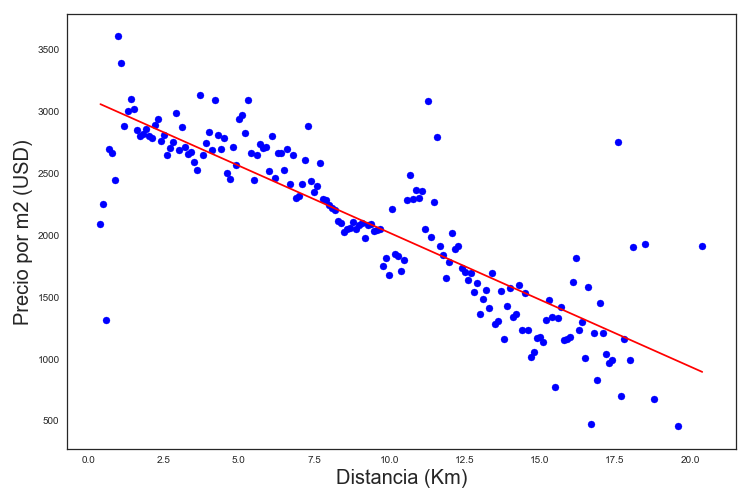

In [90]:
resultados = caba_para_mapa.loc[:,('dist_a_tren','price_usd_per_m2')].groupby('dist_a_tren').mean().reset_index()
titulo = 'Relacion entre distancia a estacion de tren vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_tren','price_usd_per_m2',titulo,'Distancia (Km)','Precio por m2 (USD)')

## Relacion entre distancia a una universidad vs precio por m2 CABA

In [91]:
univ = pd.read_csv('datos/datasets/CABA/latlon/universidades.csv',error_bad_lines=False)
univ['lat-lon']= [(x, y) for x,y in zip(univ['LAT'], univ['LNG'])]

In [92]:
caba_para_mapa['dist_a_univ'] = [distancia_minima(x, list(univ['lat-lon'])) for x in caba_para_mapa['lat-lon']]

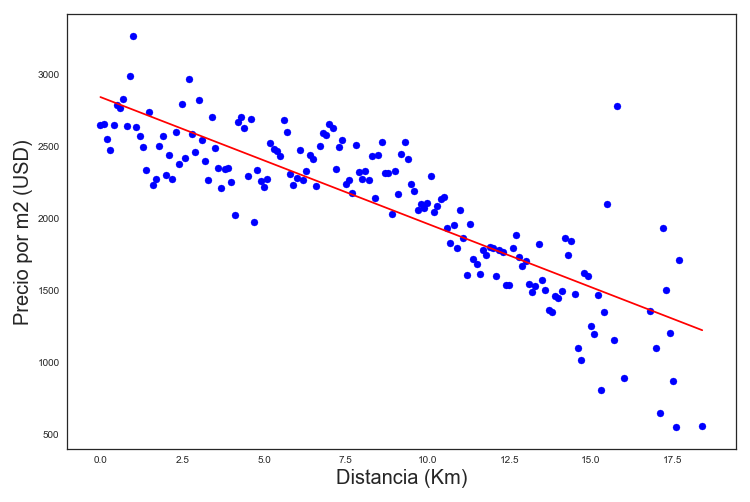

In [93]:
resultados = caba_para_mapa.loc[:,('dist_a_univ','price_usd_per_m2')].groupby('dist_a_univ').mean().reset_index()
titulo = 'Relacion entre distancia a una universidad vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_univ','price_usd_per_m2',titulo,'Distancia (Km)','Precio por m2 (USD)')

## Relacion entre distancia a una villas (o asentamiento) vs precio por m2 CABA

In [94]:
villas = pd.read_csv('datos/datasets/no_CABA/poligonos/informacin-socioeconmica-asentamientos-y-villas-ong-techo.csv')
villas= villas.loc[villas['provincia']=='CABA']
villas['geojson']= [shape(geojson.loads(x)).centroid.xy for x in villas['geojson'].values]
villas['geojson']  = [(x[1][0],x[0][0]) for x in villas['geojson']]

In [95]:
caba_para_mapa.loc[:,('dist_a_villa')] = [distancia_minima(x,list(villas.loc[:,('geojson')])) for x in caba_para_mapa.loc[:,('lat-lon')]] 

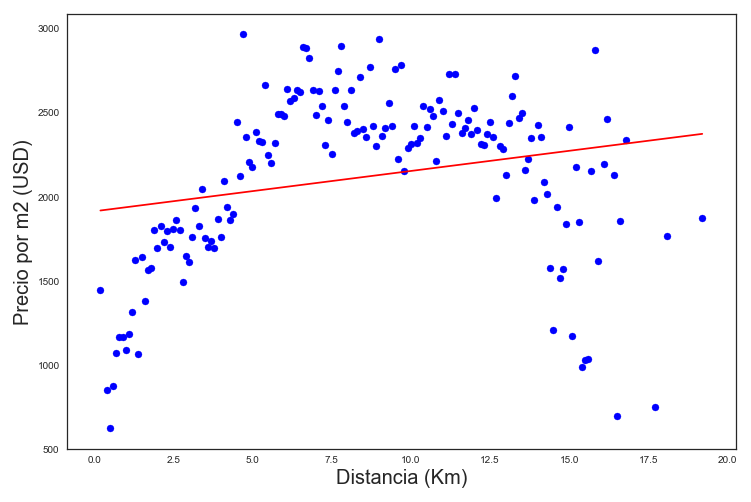

In [96]:
resultados = caba_para_mapa.loc[:,('dist_a_villa','price_usd_per_m2')].groupby('dist_a_villa').mean().reset_index()
titulo = 'Relacion entre distancia a una villas (o asentamiento) vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_villa','price_usd_per_m2',titulo,'Distancia (Km)','Precio por m2 (USD)')

In [97]:
zonas_anegadas=pd.read_csv('datos/datasets/CABA/poligonos/sitios-pasibles-de-anegamiento-por-precipitacion-2014.csv')
zonas_anegadas['lat-lon']= [loads(x).centroid.xy for x in zonas_anegadas['WKT'].values]
zonas_anegadas['lat-lon']= [(x[1][0],x[0][0]) for x in zonas_anegadas['lat-lon']]

In [98]:
#gp.polygons(zonas_anegadas['lon'],zonas_anegadas['lat'],zonas_anegadas['cluster'])

In [99]:
caba_para_mapa['dist_a_zona_anegada'] = [distancia_minima(x, list(zonas_anegadas['lat-lon'])) for x in caba_para_mapa['lat-lon']]

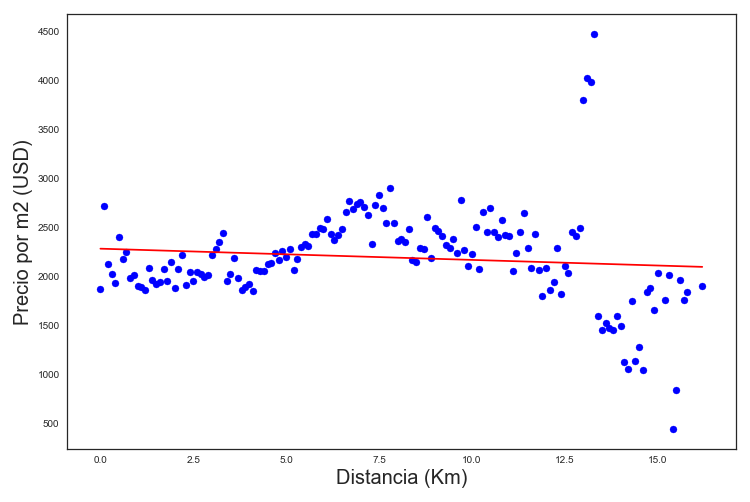

In [100]:
resultados = caba_para_mapa.loc[:,('dist_a_zona_anegada','price_usd_per_m2')].groupby('dist_a_zona_anegada').mean().reset_index()
titulo = 'Cercania entre zonas anegadas y precio por m2'
plotear_distancias(resultados,'dist_a_zona_anegada','price_usd_per_m2',titulo,'Distancia (Km)','Precio por m2 (USD)')

# <span style="color:red"> Poner nombre a ejes de graficos y refactorizar. Insertar columnas adicionales como a estrenar, con jardin, con gimnasio en dataframe principal